# Support Vector Machines (SVM) Project

This project demonstrates the implementation and analysis of Support Vector Machines, including custom implementation using the Pegasos algorithm, handling class imbalance, and kernel selection for non-linear classification.

## Project Overview

This project covers:

1. **Pegasos Algorithm**: Building an SVM classifier from scratch using the efficient stochastic subgradient approach
2. **Class Imbalance**: Understanding how imbalanced and non-separable data affect SVM decision boundaries
3. **Hyperparameter Optimization**: Using GridSearchCV to explore multiclass strategies, loss functions, and regularization
4. **Kernel Methods**: Comparing polynomial and RBF kernels for non-linearly separable data

## Part 1: Implementing the Pegasos SVM Algorithm

This project implements a simplified version of SVM using the **Pegasos** (Primal Estimated sub-GrAdient SOlver for SVM) algorithm, introduced by Shalev-Shwartz et al. (2011). This algorithm provides an efficient stochastic subgradient approach to SVM optimization.

### Algorithm Overview

Pegasos is a stochastic gradient descent method that:
- Uses a single random sample per iteration (or mini-batch)
- Updates weights using subgradient of the hinge loss
- Projects weights onto a ball to maintain regularization
- Converges efficiently even for large datasets

**Key Advantages:**
- Simpler than dual formulation methods
- Efficient for large-scale problems
- Naturally handles regularization
- Can be extended to mini-batch variants

**Reference**: Shalev-Shwartz et al. (2011) - See reading materials section for full paper details.



![alt text](https://snag.gy/Gpi1Mk.jpg)


### Implementation: PegasosSVM Class

### Implementation Details

**1. Data Preprocessing:**
- **1-padding**: Add column of ones to features (bias term integrated into weight vector)
- **Label conversion**: Transform labels from {0, 1} to {-1, 1} format
- **Feature normalization**: Use `StandardScaler` and `Pipeline` for consistent preprocessing

**2. Decision Function:**
The `decision_function` computes the signed Euclidean distance from each point to the decision boundary:
- **Magnitude**: Distance from the boundary
- **Sign**: Positive = above hyperplane, Negative = below hyperplane
- **Zero**: Points on the decision boundary
- **Use**: Can be used for classification and probability estimation

In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


class Padder(object):
    """
    Padder for feature matrix
    """
    def __init__(self):
        pass
    
    def fit(self, X: np.ndarray, y=None) -> 'Padder':
        """
        Fit Padder (does nothing)

        Args:
            X np.ndarray of shape m*n
            y None ignored, added for compatibility with sklearn Pipeline
        Returns:
            self
        """
        return self
        
    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Pad X with column of ones

        Args:
            X np.ndarray of shape m*n
        Returns:
            np.ndarray of shape m*(n+1) with column ofd ones to the right
        """
        return np.hstack([X, np.ones((X.shape[0], 1))])
        
    
class PegassosSVM(object):
    def __init__(self, regularization=2*1e-4, num_iter=10000, tolerance=0.001, verbose=False):
        """
        Pegasos SVC estimator

        Args:
            regularization float, default is 2*10^-4 like in the paper
            num_iter int number of iterations
            tolerance float tolerance of w change after which the estimator does the early stop
            verbose bool logger verbosity
        """
        self.num_iter = num_iter
        self.verbose = verbose
        self.lambda_ = regularization
        self.tolerance = tolerance
        self.w = None
        self.pipeline = Pipeline([('scaler', StandardScaler()), ('padder', Padder())])    

    def _transform_target(self, y: np.ndarray) -> np.ndarray:
        """
        Transforms target from {0,1} to {-1,1}

        Args:
            y np.ndarray of shape (n,)
        Returns:
            np.ndarray of shape (n,) with -1s instead of 0s
        """
        return np.where(y == 1, 1, -1)

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'PegassosSVM':
        """
        Fits the SVC using Pegasos optimization

        Args:
            X np.ndarray of shape (n, m)
            y np.ndarray of shape (n,)
        Returns:
            self fitted SVC
        """
        X_pad = self.pipeline.fit_transform(X)
        y_transformed = self._transform_target(y)
        self.w = np.zeros(X_pad.shape[1])
        
        for iteration in range(self.num_iter):
            old_w = self.w.copy()
            i = np.random.randint(0, X.shape[0])
            eta = 1.0 / (self.lambda_ * (iteration + 1))
            if self.verbose:
                print(f"Iteration {iteration + 1}, choosing i={i}")
            hinge_grad = y[i] * (self.w @ X_pad[i])
            if self.verbose:
                print(f"hinge_grad={hinge_grad}")
            if hinge_grad < 1.0:
                self.w = (1 - eta * self.lambda_) * self.w + eta * y[i] * X_pad[i]
            else:
                self.w = (1 - eta * self.lambda_) * self.w
            if np.linalg.norm(self.w) > 0:
                self.w = min(1.0, 1.0 / (np.sqrt(self.lambda_) * np.linalg.norm(self.w))) * self.w
            if iteration > 10 and np.linalg.norm(self.w - old_w) < self.tolerance:
                if self.verbose:
                    print(f"Early stopping at step {iteration + 1}")
                break
        return self

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        """
        Calculates distance from all the points to the decision boundary

        Args:
            X np.ndarray of shape n * (m + 1)
        Rerurns:
            np.ndarray of shape (n,) with distances to the decisiom boundary
        """
        return X @ self.w


    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Returns predictions {-1, 1} for X

        Args:
            X np.ndarray of shape n * m
        Returns:
            np.ndarray of shape (n,) with predictions
        """
        if self.w is None:
            raise ValueError("Model has not been fit!")
        X_pad = self.pipeline.transform(X)
        decision = self.decision_function(X_pad)
        if self.verbose:
            print(f"Decisions: {decision}")
        return np.sign(decision)

    def fit_predict(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Fits model on X and y
        Returns predictions {-1, 1} for X

        Args:
            X np.ndarray of shape (n,m)
            y np.ndarray of shape (n,)
        Returns:
            np.ndarray of shape (n,) with predictions
        """
        self.fit(X, y)
        return self.predict(X)

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        """
        Calculates accuracy of the model

        Args:
            X np.ndarray of shape (n,m)
            y np.ndarray of shape (n,)
        Returns:
            accuracy float in range [0, 1]
        """
        y_pred = self.predict(X)
        return np.mean(self._transform_target(y) == y_pred)

    def get_params(self, deep=False) -> dict:
        """
        Get parameters of the model

        Args:
            deep bool ignored, added for compatibility with sklearn CV

        Returns:
            dict with parameters
        """
        return {
            'regularization': self.lambda_,
            'num_iter': self.num_iter,
            'tolerance': self.tolerance
        }

    def set_params(self, **params) -> 'PegassosSVM':
        """
        Set regularization of the model

        Args:
            params of the model
        Returns:
            SVC with updated params
        """
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
        return self

In [3]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)

In [4]:
pegasos = PegassosSVM(verbose=False)
preds = pegasos.fit_predict(X, y)
pegasos.score(X, y)

np.float64(0.8927943760984183)

## 1.2
The initial accuracy looks solid. Let's compare with `sklearn.SVC`

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

pegasos_cvs = cross_val_score(pegasos, X, y, cv=20)

svc = SVC()
svc_cvs = cross_val_score(svc, X, y, cv=20)

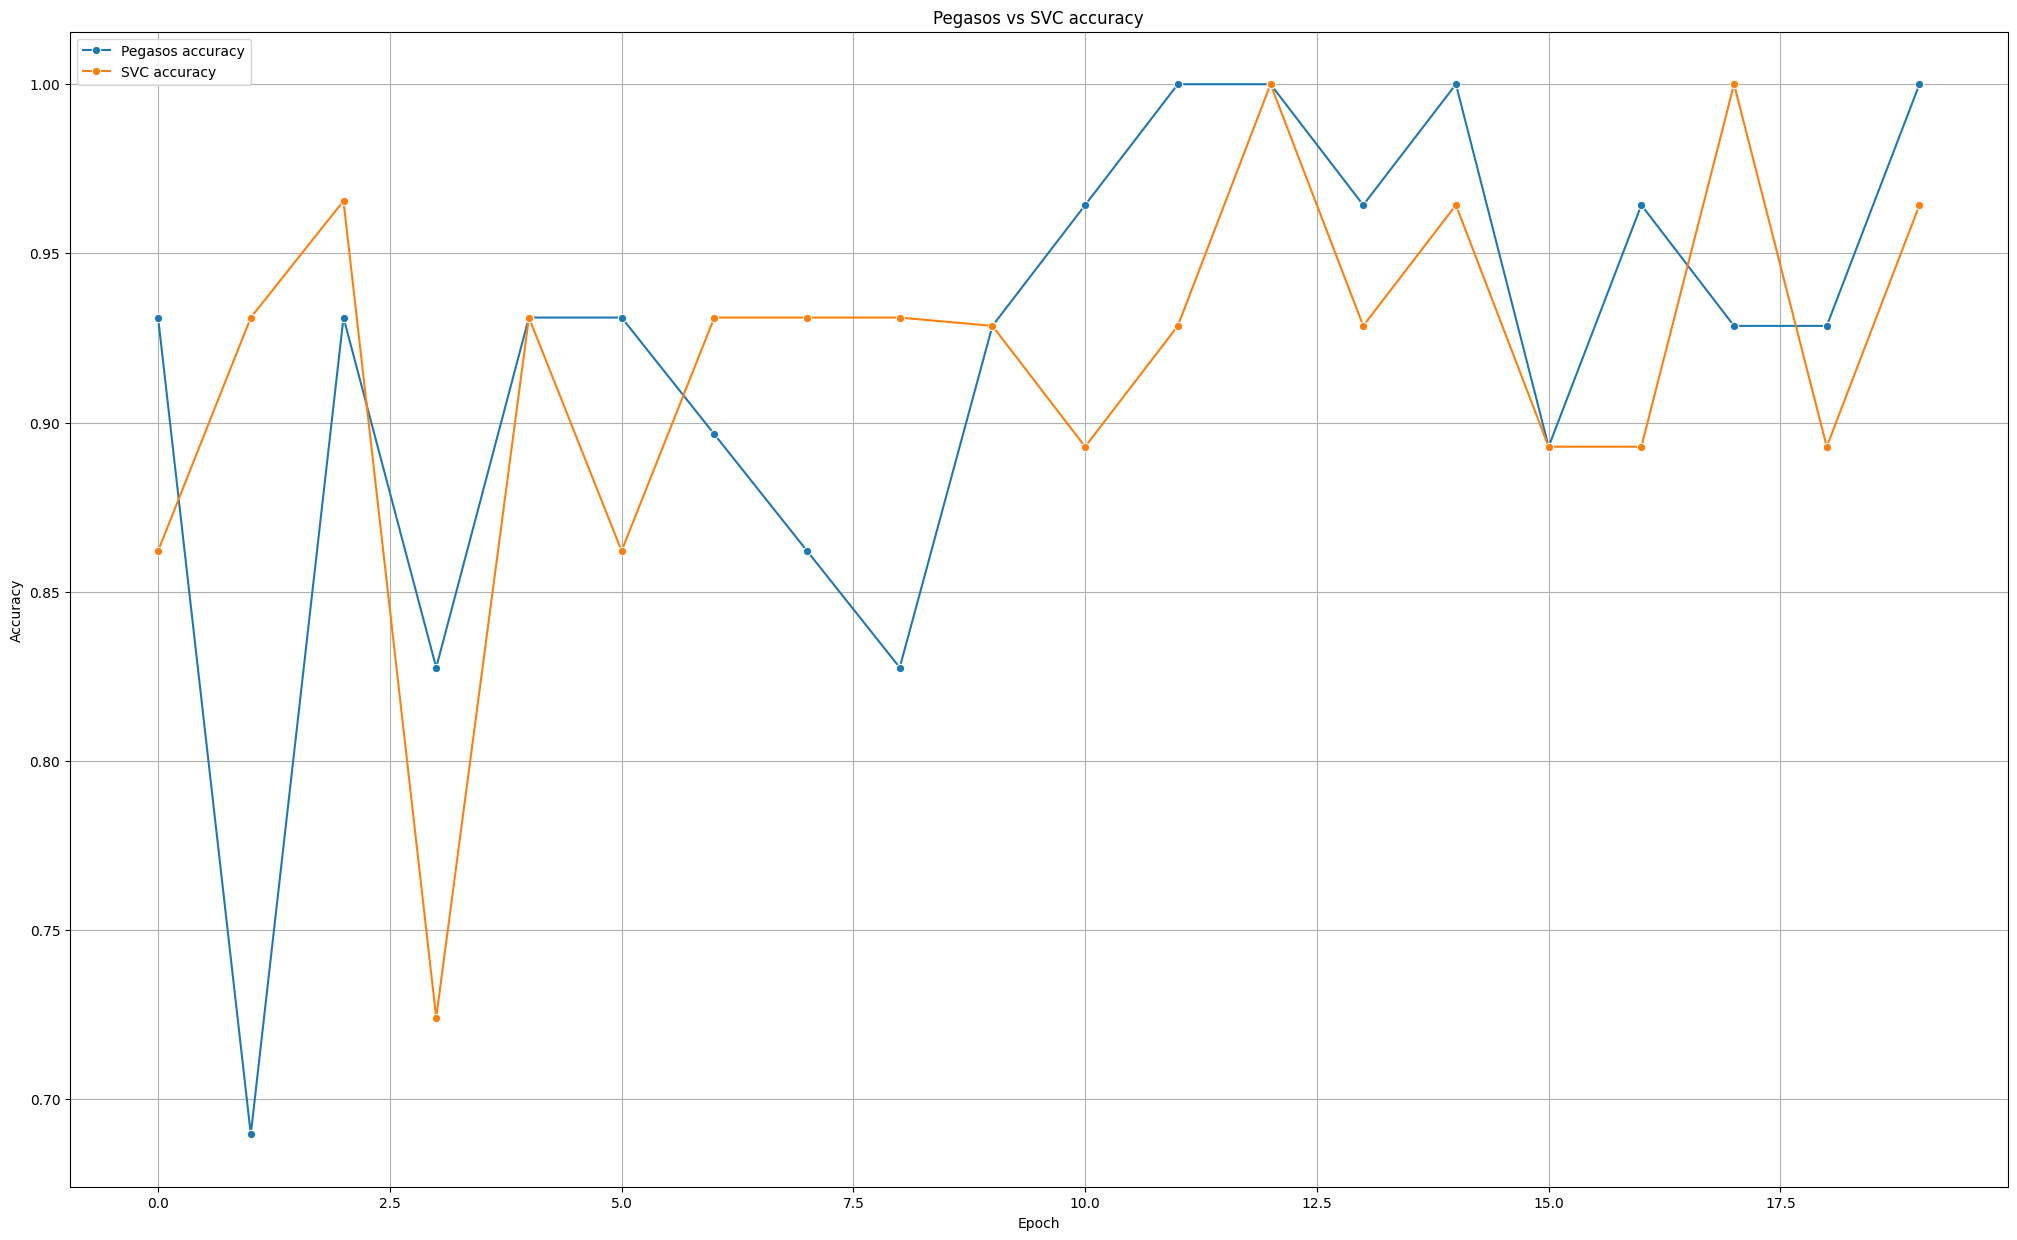

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(25,15))
sns.lineplot(x=range(20), y=pegasos_cvs, marker='o', label="Pegasos accuracy")
sns.lineplot(x=range(20), y=svc_cvs, marker='o', label="SVC accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Pegasos vs SVC accuracy")
plt.grid()
plt.show();

### Comparison Results

**Finding**: Since Pegasos is a stochastic estimator, larger variance in accuracy is observed across cross-validation folds. However, the algorithm can eventually generate results as good as scikit-learn's SVC.

**Key Observations:**
- **Variance**: Stochastic nature leads to more variability in performance
- **Convergence**: With sufficient iterations, Pegasos achieves comparable accuracy
- **Efficiency**: Pegasos is computationally efficient, making it suitable for large datasets
- **Tradeoff**: Variance vs. computational efficiency

### Regularization Parameter Analysis

The effect of the regularization parameter $\lambda$ on model performance is studied. This analysis helps understand the bias-variance tradeoff in SVM optimization.

In [7]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(estimator=pegasos, X=X, y=y, param_name='regularization', param_range=np.logspace(-9, 4, 20), verbose=2, n_jobs=4)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END ..............regularization=2.3357214690901214e-08; total time=   0.4s
[CV] END ...............................regularization=1e-09; total time=   0.4s
[CV] END ..............regularization=1.1288378916846883e-07; total time=   0.4s
[CV] END ...............regularization=4.832930238571752e-09; total time=   0.5s
[CV] END ..............regularization=1.2742749857031348e-05; total time=   0.4s
[CV] END ...............regularization=6.158482110660267e-05; total time=   0.4s
[CV] END ...............regularization=5.455594781168515e-07; total time=   0.5s
[CV] END ..............regularization=2.6366508987303555e-06; total time=   0.5s
[CV] END ..............regularization=0.00029763514416313193; total time=   0.3s
[CV] END ...............regularization=0.0014384498882876629; total time=   0.4s
[CV] END .................regularization=0.03359818286283781; total time=   0.5s
[CV] END ...............regularization=0.0069519279617756054; total time=   0.5s
[CV] END ..................r

[Parallel(n_jobs=4)]: Done  50 out of 100 | elapsed:   10.7s remaining:   10.7s


[CV] END ...............regularization=0.0069519279617756054; total time=   0.4s
[CV] END ..................regularization=0.7847599703514623; total time=   0.3s
[CV] END .................regularization=0.03359818286283781; total time=   0.4s
[CV] END .................regularization=0.16237767391887242; total time=   0.4s
[CV] END ...................regularization=3.792690190732254; total time=   0.3s
[CV] END ..................regularization=428.13323987193957; total time=   0.3s
[CV] END ..................regularization=18.329807108324374; total time=   0.4s
[CV] END ...................regularization=88.58667904100832; total time=   0.5s
[CV] END ....................regularization=2069.13808111479; total time=   0.4s
[CV] END .............................regularization=10000.0; total time=   0.4s
[CV] END ...............................regularization=1e-09; total time=   0.4s
[CV] END ..............regularization=2.3357214690901214e-08; total time=   0.3s
[CV] END ...............regu

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   16.1s finished


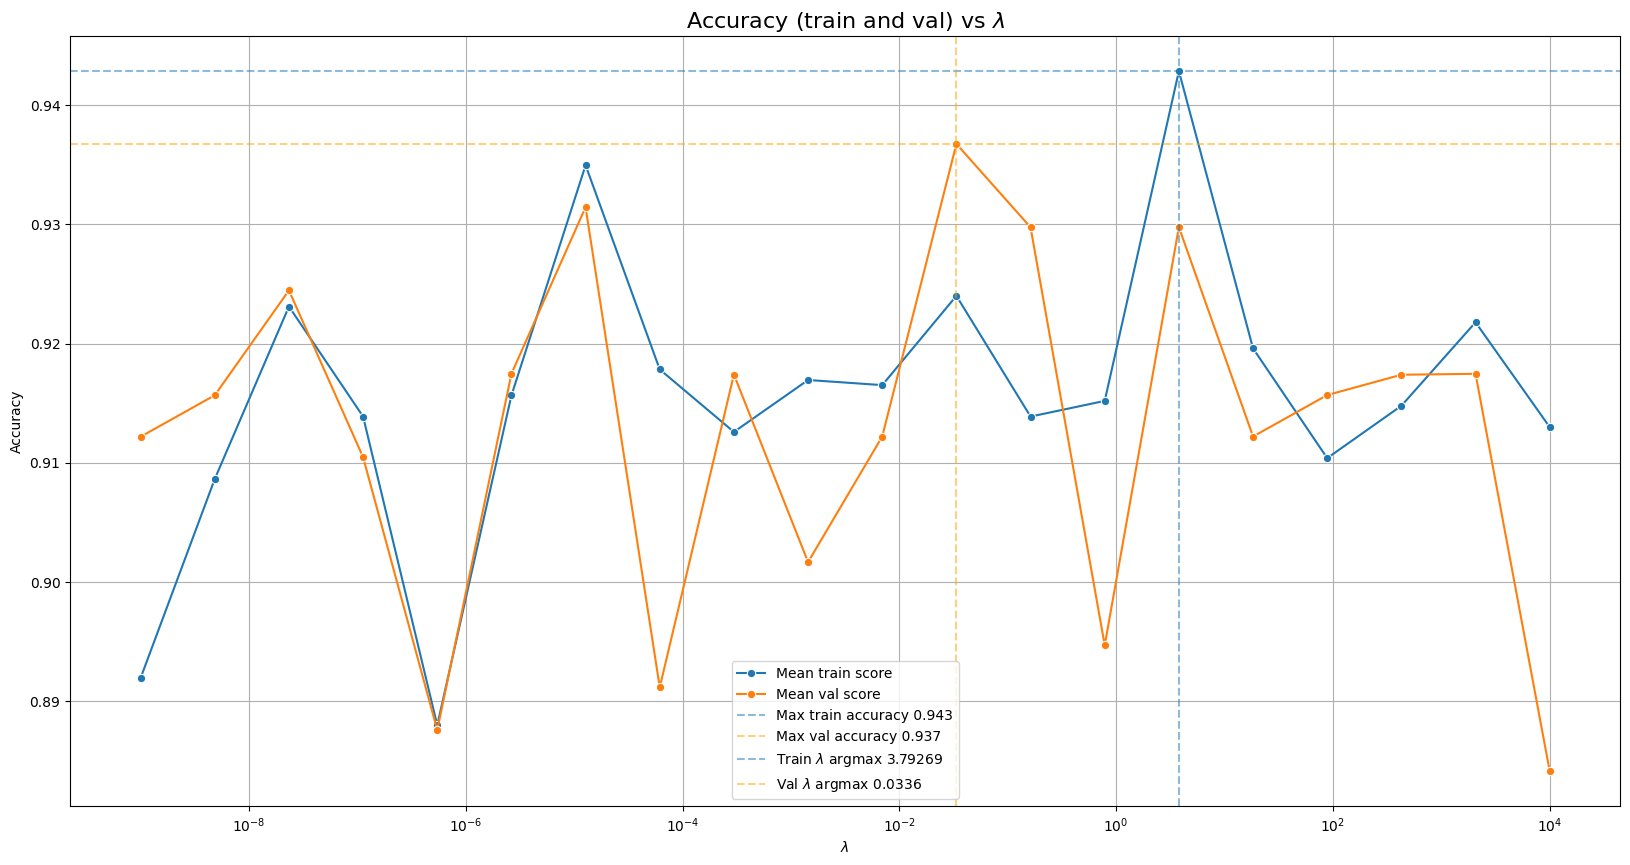

In [8]:
x = np.logspace(-9, 4, 20)

max_train_acc, min_train_acc = train_scores.mean(axis=1).max(), train_scores.mean(axis=1).min()
argmax_train_acc, argmin_train_acc = train_scores.mean(axis=1).argmax(), train_scores.mean(axis=1).argmin()
max_test_acc, min_test_acc = test_scores.mean(axis=1).max(), test_scores.mean(axis=1).min()
argmax_test_acc, argmin_test_acc = test_scores.mean(axis=1).argmax(), test_scores.mean(axis=1).argmin()


plt.figure(figsize=(20, 10))
sns.lineplot(x=x, y=train_scores.mean(axis=1), label='Mean train score', marker='o')
sns.lineplot(x=x, y=test_scores.mean(axis=1), label='Mean val score', marker='o')
plt.axhline(y=max_train_acc, linestyle='--', alpha=0.5, label=f'Max train accuracy {round(max_train_acc, 3)}')
plt.axhline(y=max_test_acc, linestyle='--', alpha=0.5, label=f'Max val accuracy {round(max_test_acc, 3)}', color='orange')
plt.axvline(x=x[argmax_train_acc], linestyle='--', alpha=0.5, label=rf'Train $\lambda$ argmax {round(x[argmax_train_acc], 6)}')
plt.axvline(x=x[argmax_test_acc], linestyle='--', alpha=0.5, label=rf'Val $\lambda$ argmax {round(x[argmax_test_acc], 4)}', color='orange')
plt.xscale("log")
plt.title(r'Accuracy (train and val) vs $\lambda$', fontsize=16)
plt.xlabel(r'$\lambda$')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show();


### Regularization Analysis Results

**Key Findings:**

1. **Stochastic Variance**: As a stochastic estimator, Pegasos shows some variance in accuracy across different $\lambda$ values

2. **Performance Range**: Both train and validation scores achieve good performance ($\geq 90\%$) across a wide range of $\lambda$ values

3. **Overfitting Analysis**: Train and validation scores are in the same order of magnitude, indicating that the classifier doesn't significantly overfit on either set

4. **Optimal Range**: The optimal $\lambda$ values maintain good generalization while preventing overfitting

**Conclusion**: The regularization parameter $\lambda$ provides effective control over model complexity, with the algorithm showing robustness across a range of values.

### Learning Curve Analysis

This section investigates how training set size impacts model performance. This analysis reveals the relationship between data availability and model accuracy.

In [9]:
from sklearn.model_selection import learning_curve

train_size_abs, train_scores, test_scores = learning_curve(estimator=pegasos, X=X, y=y, train_sizes=np.linspace(0.01, 0.99, 30), verbose=1, n_jobs=4)

[learning_curve] Training set sizes: [  4  19  35  50  66  81  96 112 127 142 158 173 189 204 219 235 250 265
 281 296 312 327 342 358 373 388 404 419 435 450]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   11.9s finished


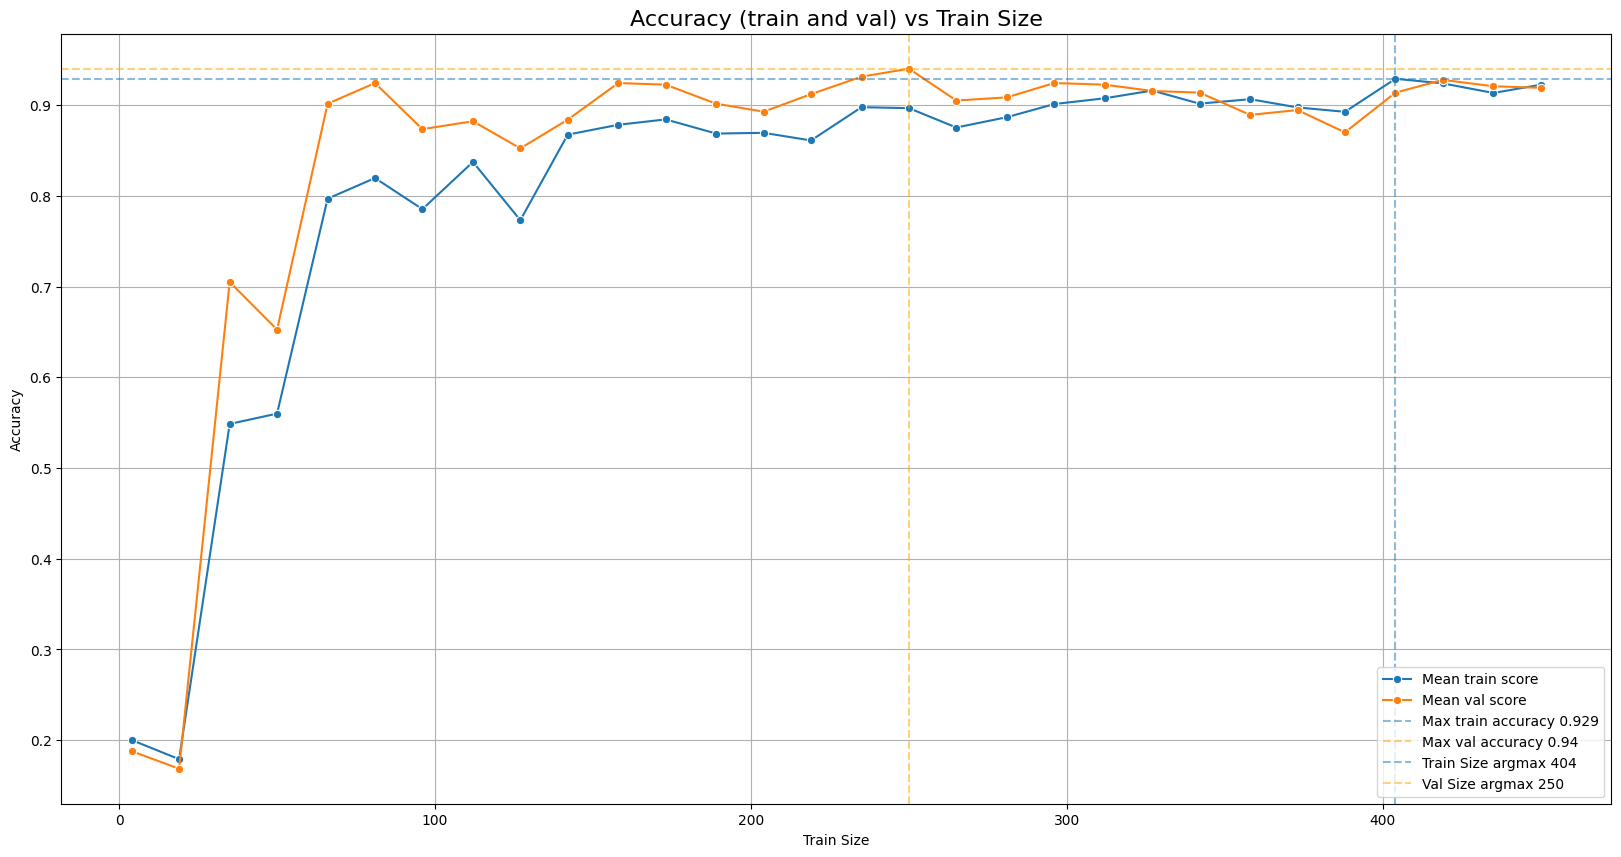

In [10]:
x = train_size_abs

max_train_acc, min_train_acc = train_scores.mean(axis=1).max(), train_scores.mean(axis=1).min()
argmax_train_acc, argmin_train_acc = train_scores.mean(axis=1).argmax(), train_scores.mean(axis=1).argmin()
max_test_acc, min_test_acc = test_scores.mean(axis=1).max(), test_scores.mean(axis=1).min()
argmax_test_acc, argmin_test_acc = test_scores.mean(axis=1).argmax(), test_scores.mean(axis=1).argmin()


plt.figure(figsize=(20, 10))
sns.lineplot(x=x, y=train_scores.mean(axis=1), label='Mean train score', marker='o')
sns.lineplot(x=x, y=test_scores.mean(axis=1), label='Mean val score', marker='o')
plt.axhline(y=max_train_acc, linestyle='--', alpha=0.5, label=f'Max train accuracy {round(max_train_acc, 3)}')
plt.axhline(y=max_test_acc, linestyle='--', alpha=0.5, label=f'Max val accuracy {round(max_test_acc, 3)}', color='orange')
plt.axvline(x=x[argmax_train_acc], linestyle='--', alpha=0.5, label=rf'Train Size argmax {round(x[argmax_train_acc], 6)}')
plt.axvline(x=x[argmax_test_acc], linestyle='--', alpha=0.5, label=rf'Val Size argmax {round(x[argmax_test_acc], 3)}', color='orange')
plt.title(r'Accuracy (train and val) vs Train Size', fontsize=16)
plt.xlabel(r'Train Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show();

plt.show();

### Learning Curve Results

**Key Observations:**

1. **Small Training Sets**: Worst accuracy occurs when training size is extremely small due to insufficient data for learning

2. **Training Score Behavior**: Train score is highest when almost all data is in the training set, as the model can overfit to the training data

3. **Optimal Test Performance**: Test score peaks at a balanced train/validation split, where:
   - The model has enough data to learn effectively
   - There's sufficient validation data to prevent overfitting
   - The bias-variance tradeoff is optimized

4. **Stability**: After reaching a balanced training size, scores stabilize and fluctuate around consistent values, as additional training data doesn't provide new information for validation

**Practical Implication**: The learning curve helps determine the optimal train/validation split and identifies when collecting more data may not improve performance.

### Mini-Batch Pegasos Implementation

The Pegasos algorithm is extended to support mini-batch updates, where the loss is summed over multiple samples before updating weights. This variant can provide:
- Reduced variance compared to stochastic version
- Better computational efficiency through vectorization
- Faster convergence in some cases


In [11]:
class PegasosMinibatchSVM(PegassosSVM):
    def __init__(self, batch_size=10, regularization=2*1e-4, num_iter=10000, tolerance=0.001, verbose=False):
        """
        Pegasos MiniBatch SVC estimator

        Args:
            batch_size int size of the minibatch
            regularization float, default is 2*10^-4 like in the paper
            num_iter int number of iterations
            tolerance float tolerance of w change after which the estimator does the early stop, chosen like in SVC
            verbose bool logger verbosity
        """
        super(PegasosMinibatchSVM, self).__init__(regularization, num_iter, tolerance, verbose)
        self.batch_size = batch_size

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'PegassosMinibatchSVM':
        """
        Fits the SVC using Pegasos Minibatch optimization

        Args:
            X np.ndarray of shape (n, m)
            y np.ndarray of shape (n,)
        Returns:
            self fitted SVC
        """
        X_pad = self.pipeline.fit_transform(X)
        y_transformed = self._transform_target(y)
        self.w = np.zeros(X_pad.shape[1])
        
        for iteration in range(self.num_iter):
            old_w = self.w.copy()
            batch = np.random.randint(0, X.shape[0], size=min(self.batch_size, X.shape[0]))
            eta = 1.0 / (self.lambda_ * (iteration + 1))
            if self.verbose:
                print(f"Iteration {iteration + 1}")
            positive_x = y * (self.w @ X_pad.T) < 1.0
            self.w = (1.0 - self.lambda_ * eta) * self.w + eta / min(self.batch_size, X.shape[0]) * (y[positive_x].reshape(-1, 1) * X_pad[positive_x]).sum(axis=0)
            
            # Project onto ball: ||w|| <= 1/√λ
            norm = np.linalg.norm(self.w)
            if norm > 1.0 / np.sqrt(self.lambda_):
                self.w = self.w / (norm * np.sqrt(self.lambda_))
            
            if iteration > 10 and np.linalg.norm(old_w - self.w) < self.tolerance:
                if self.verbose:
                    print(f"Early stopping at step {iteration + 1}")
                break
        return self

    def get_params(self, deep=False) -> dict:
        """
        Get parameters of the model

        Args:
            deep bool ignored, added for compatibility with sklearn CV

        Returns:
            dict with parameters
        """
        return {
            'batch_size': self.batch_size,
            'regularization': self.lambda_,
            'num_iter': self.num_iter,
            'tolerance': self.tolerance
        }


In [12]:
pegasos_mb = PegasosMinibatchSVM(batch_size=10)
pegasos_mb.fit(X, y)
pegasos_mb.score(X, y)

np.float64(0.9420035149384886)

### Stochastic vs Mini-Batch Comparison

The performance of stochastic and mini-batch Pegasos variants is compared across different batch sizes to understand the tradeoffs between variance, efficiency, and convergence speed.

In [13]:
from collections import defaultdict
from tqdm import tqdm

scores = defaultdict(list)
for batch_size in tqdm([10, 50, 100, 200, 400], total=5):
    pegasos_mb = PegasosMinibatchSVM(batch_size=batch_size)
    scores[batch_size] = cross_val_score(pegasos_mb, X, y, cv=20).tolist()
    

100%|██████████| 5/5 [00:35<00:00,  7.06s/it]


In [14]:
for batch_size, batch_scores in scores.items():
    print(f"For batch size {batch_size} avg accuracy is {np.mean(batch_scores)}")

For batch size 10 avg accuracy is 0.9356527093596059
For batch size 50 avg accuracy is 0.9408866995073891
For batch size 100 avg accuracy is 0.9372536945812806
For batch size 200 avg accuracy is 0.9231527093596059
For batch size 400 avg accuracy is 0.9058497536945813


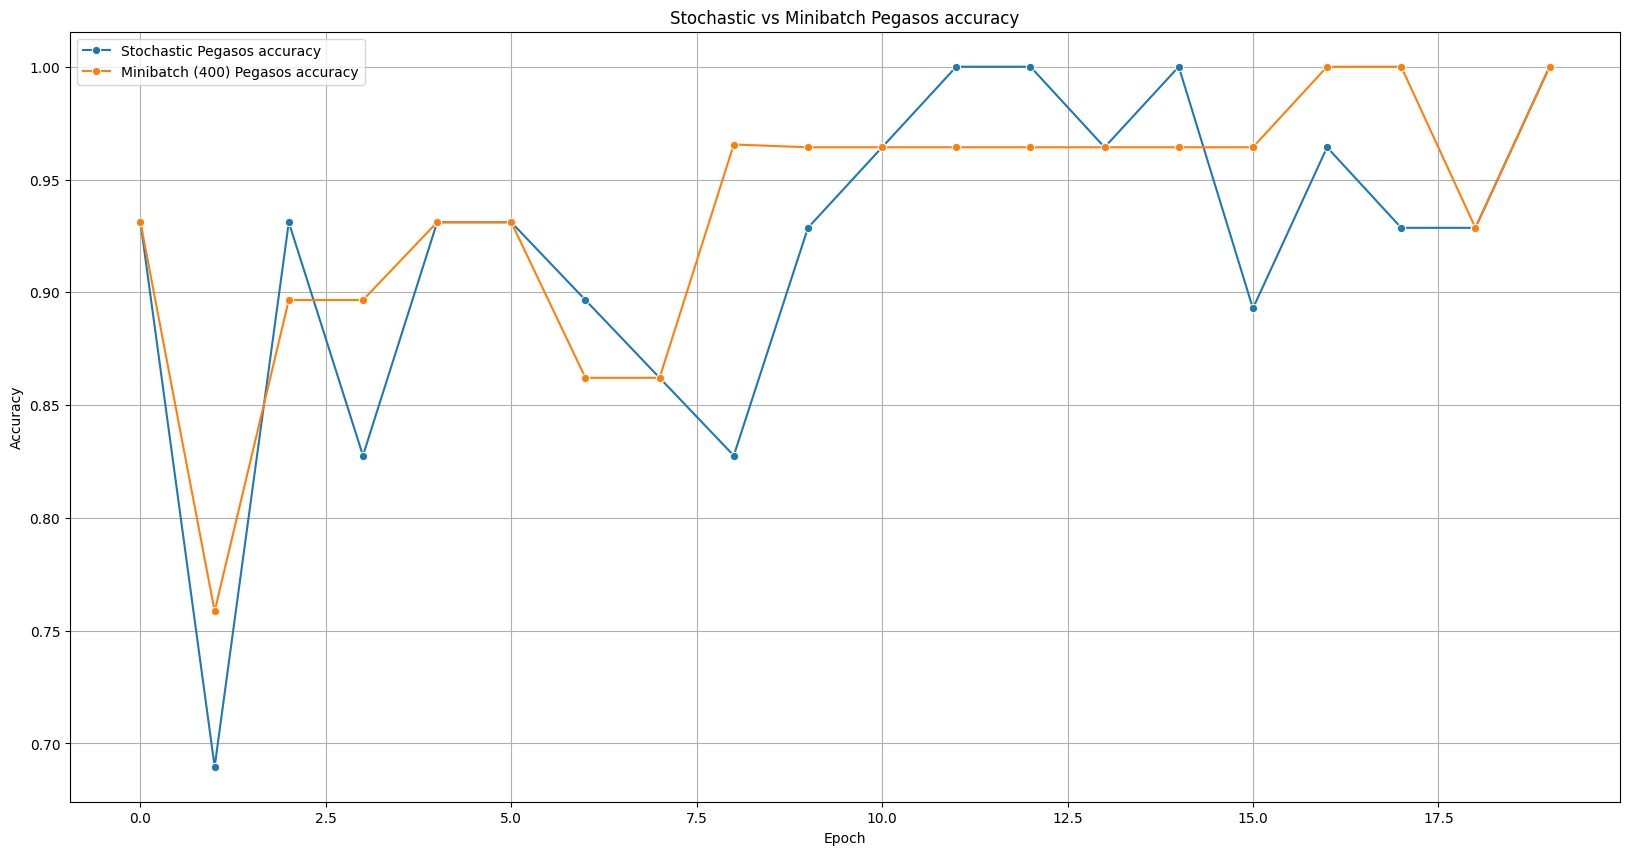

In [15]:
plt.figure(figsize=(20,10))
sns.lineplot(x=range(20), y=pegasos_cvs, marker='o', label="Stochastic Pegasos accuracy")
sns.lineplot(x=range(20), y=scores[10], marker='o', label=f"Minibatch ({batch_size}) Pegasos accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Stochastic vs Minibatch Pegasos accuracy")
plt.grid()
plt.show();

### Mini-Batch Results

**Finding**: The accuracy doesn't decrease for mini-batch Pegasos compared to the stochastic variant.

**Key Advantages of Mini-Batch:**
1. **Efficiency**: Mini-batch processing is more computationally efficient through vectorization
2. **Reduced Variance**: Averaging over multiple samples reduces variance in gradient estimates
3. **Production Ready**: The mini-batch estimator is more suitable for production environments due to better efficiency and stability

**Conclusion**: For production use, mini-batch Pegasos is preferred over the stochastic variant due to its efficiency and maintained accuracy.

## Part 2: Class Imbalance and SVM Decision Boundaries

This section explores how SVMs handle imbalanced, non-separable classes and why this can lead to unexpected results. Understanding class weighting is crucial for real-world applications where class distributions are often skewed.

### Dataset Generation

A synthetic dataset is used with the following properties:
- **Number of samples**: 1000
- **Class imbalance**: 10% class 0, 90% class 1
- **Feature distributions**:
  - Class 0: Gaussian with $\mu_1 = (0, -d/2)$ and $\sigma_1 = 0.5$
  - Class 1: Gaussian with $\mu_2 = (0, d/2)$ and $\sigma_2 = 2.0$

**Formal Definition:**
$$p(x|y) \sim\mathcal{N}(\mu=(0, (-1)^{1-y}d/2), \sigma=0.5+1.5y)$$
$$p(y=0) = 0.1$$

In [16]:
import numpy as np

def make_data(
        d: int,
        n_samples: int = 1000,
        imbalance: float = 0.1,
        random_state: int | None = None
        ) -> tuple[np.ndarray, np.ndarray]:
    """Generate 2D Gaussian data with class imbalance.

    Class 0: ~N(μ=[0, -d/2], σ=0.5) with p=imbalance
    Class 1: ~N(μ=[0, +d/2], σ=2.0) with p=1-imbalance
    """

    rng = np.random.default_rng(random_state)

    means = np.array([[0, -d/2], [0, d/2]])
    stds = np.array([0.5, 2.0])

    # Generate imbalanced binary labels
    y = rng.binomial(1, 1-imbalance, n_samples)
    counts = np.bincount(y)

    # Generate Gaussian samples for each class
    X = np.zeros((n_samples, 2))
    for c in (0, 1):
        X[y == c] = rng.normal(loc=means[c], scale=stds[c], size=(counts[c], 2))

    return X, y

## 2.1

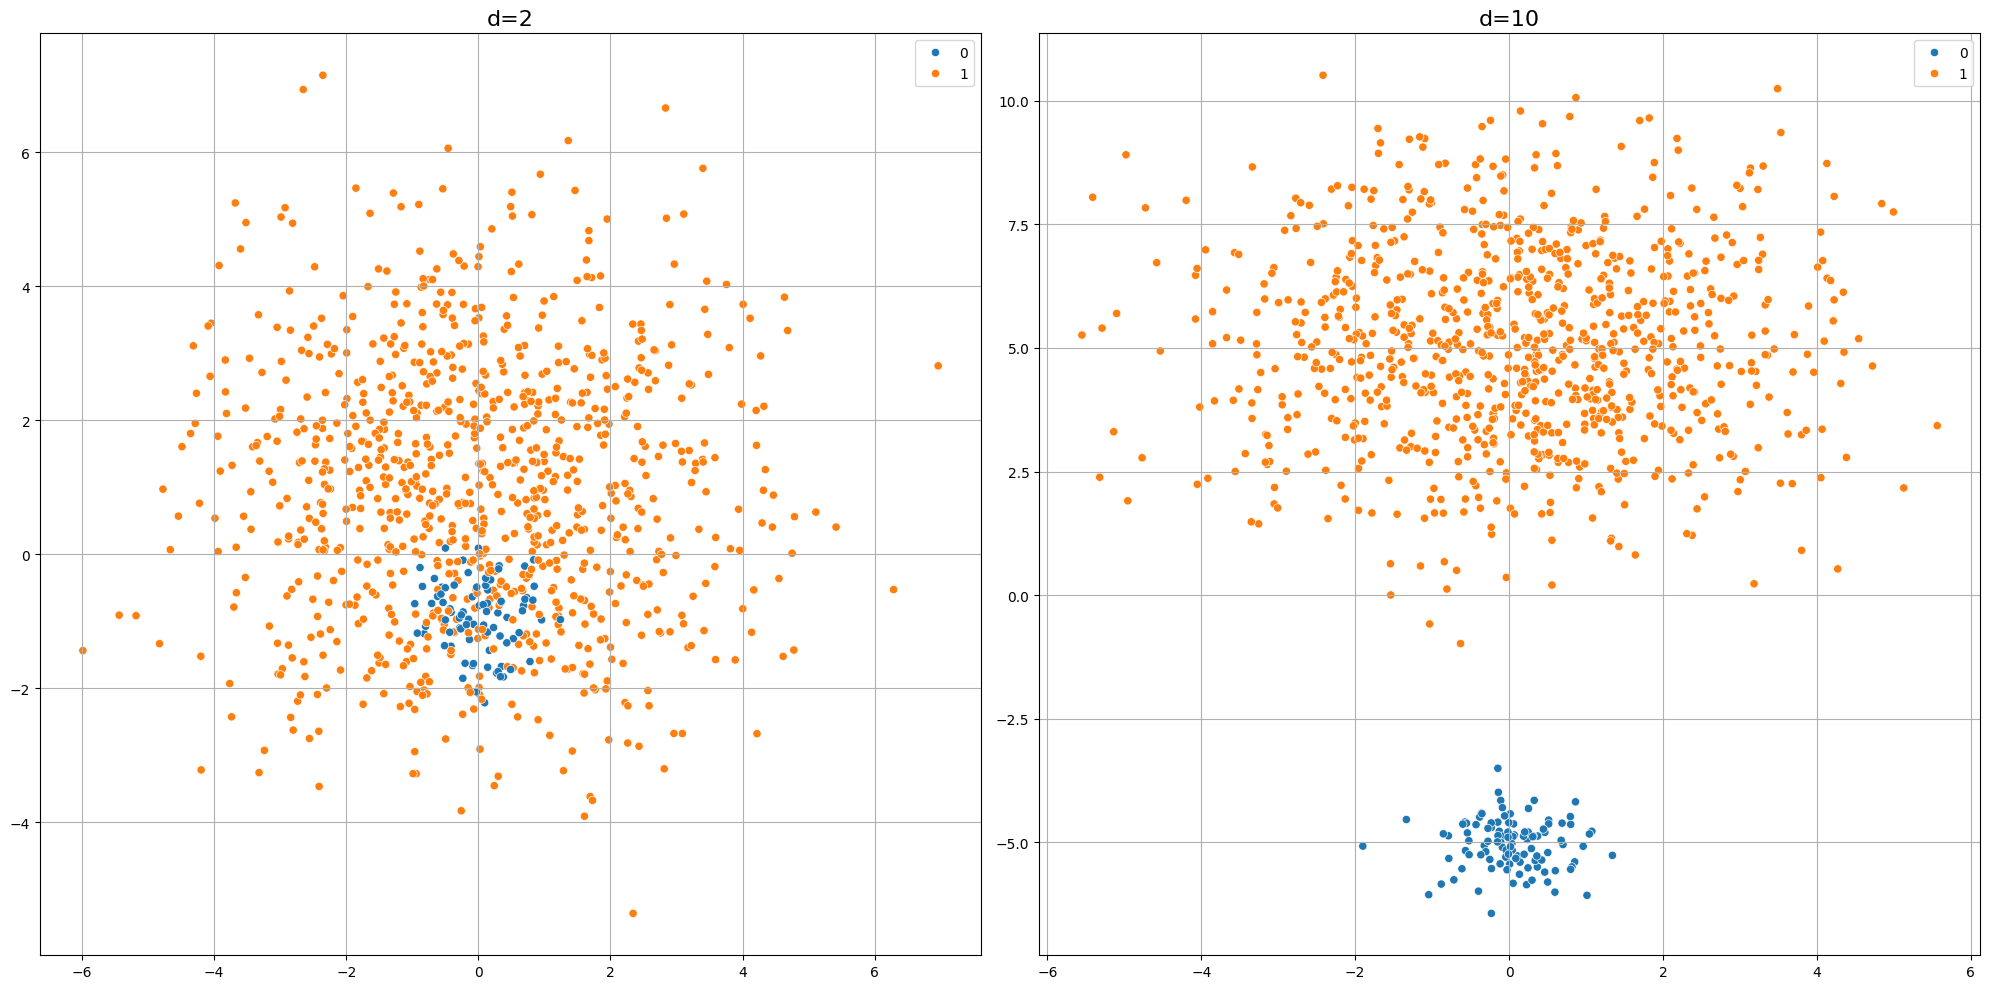

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
X2, y2 = make_data(d=2)
sns.scatterplot(x=X2[:, 0], y=X2[:, 1], hue=y2, ax=ax[0])
ax[0].set_title("d=2", fontsize=16)
ax[0].grid()

X10, y10 = make_data(d=10)
sns.scatterplot(x=X10[:, 0], y=X10[:, 1], hue=y10, ax=ax[1])
ax[1].set_title("d=10", fontsize=16)
ax[1].grid()

plt.tight_layout()
plt.show();

### Data Visualization and Expected Behavior

**Observation**: Class 0 is heavily underrepresented (10% vs 90%).

**Expected Decision Boundaries:**

1. **For $d=2$** (Non-separable, overlapping classes):
   - Class 0 lies inside the overrepresented class 1 region
   - SVM optimizes to minimize total misclassification
   - **Expected**: Decision boundary below class 1 cluster to maximize majority class accuracy
   - **Accuracy vs Balanced Accuracy**: Accuracy will be higher than balanced accuracy since it's dominated by the majority class performance

2. **For $d=10$** (Linearly separable classes):
   - Classes are well-separated in feature space
   - **Expected**: Decision boundary between the two classes
   - **Accuracy**: Both accuracy and balanced accuracy should be high and similar, as separation is clear

## 2.2

In [18]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score

lsvc = LinearSVC()
y_pred = lsvc.fit(X2, y2).predict(X2)
weight2, intercept2= lsvc.coef_[0], lsvc.intercept_[0]
acc2, balanced_acc2 = accuracy_score(y2, y_pred), balanced_accuracy_score(y2, y_pred)

y_pred = lsvc.fit(X10, y10).predict(X10)
weight10, intercept10 = lsvc.coef_[0], lsvc.intercept_[0]
acc10, balanced_acc10 = accuracy_score(y10, y_pred), balanced_accuracy_score(y10, y_pred)

In [19]:
from typing import Callable

def get_line_function(w: np.array, intercept: float, shift: float=0.0) -> Callable[[np.array], np.array]:
    """
    Get function to generate the line based on normal and intercept (and optional parallel shift)

    Args:
        w np.array of shape (2,) normal
        intercept float intercept
        shift float parallel shift in w
    Returns:
        function getting np.array of x and generating np.array of y
    """
    return lambda x: -(w[0]/w[1]) * x - (intercept + shift * np.linalg.norm(w)) / w[1]

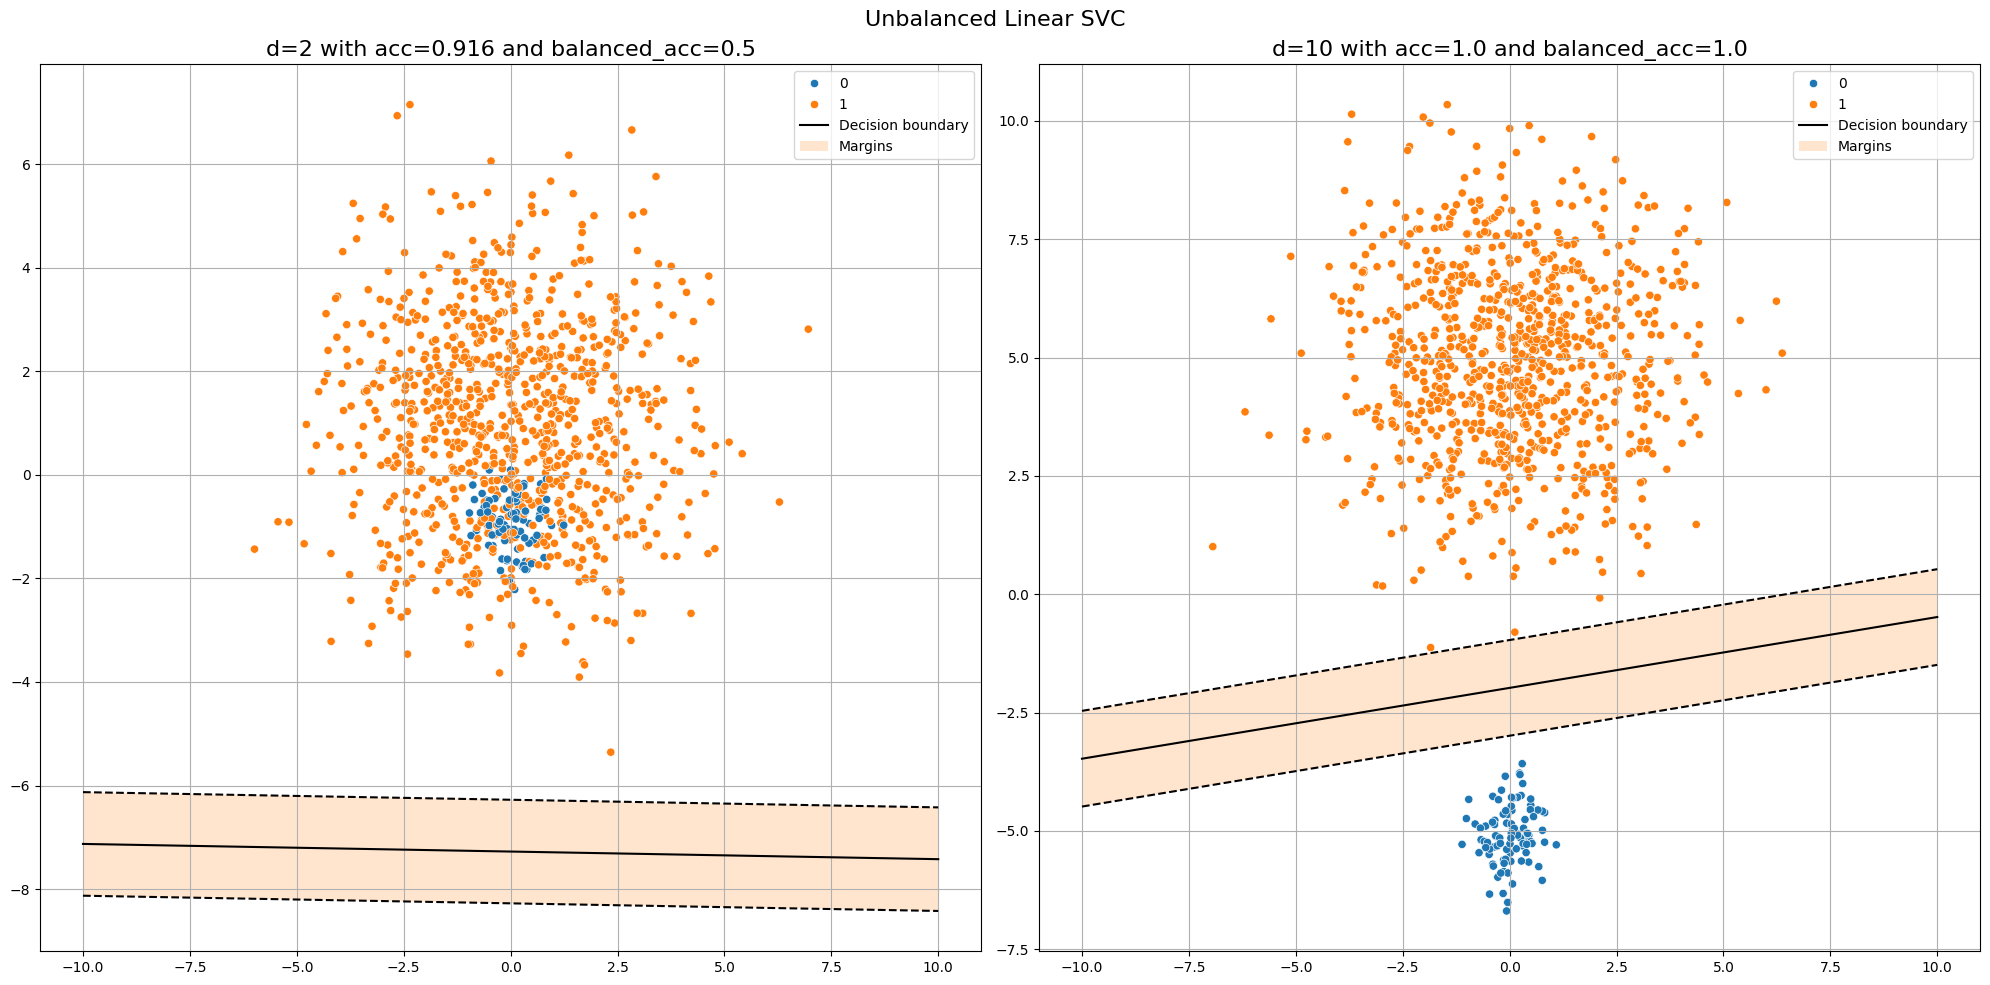

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

x = np.linspace(-10, 10, 100)
sns.scatterplot(x=X2[:, 0], y=X2[:, 1], hue=y2, ax=ax[0])
sns.lineplot(x=x, y=get_line_function(weight2, intercept2)(x), label='Decision boundary', ax=ax[0], c='k')
sns.lineplot(x=x, y=get_line_function(weight2, intercept2, shift=1)(x), ax=ax[0], linestyle='--', c='k')
sns.lineplot(x=x, y=get_line_function(weight2, intercept2, shift=-1)(x), ax=ax[0], linestyle='--', c='k')
ax[0].fill_between(x, get_line_function(weight2, intercept2, shift=-1)(x), get_line_function(weight2, intercept2, shift=1)(x), alpha=0.2, label='Margins')
ax[0].legend()
ax[0].set_title(f"d=2 with acc={acc2} and balanced_acc={round(balanced_acc2, 3)}", fontsize=16)
ax[0].grid()

X10, y10 = make_data(d=10)
sns.scatterplot(x=X10[:, 0], y=X10[:, 1], hue=y10, ax=ax[1])
sns.lineplot(x=x, y=get_line_function(weight10, intercept10)(x), label='Decision boundary', ax=ax[1], c='k')
sns.lineplot(x=x, y=get_line_function(weight10, intercept10, shift=1)(x), ax=ax[1], linestyle='--', c='k')
sns.lineplot(x=x, y=get_line_function(weight10, intercept10, shift=-1)(x), ax=ax[1], linestyle='--', c='k')
ax[1].fill_between(x, get_line_function(weight10, intercept10, shift=-1)(x), get_line_function(weight10, intercept10, shift=1)(x), alpha=0.2, label='Margins')
ax[1].legend()
ax[1].set_title(f"d=10 with acc={acc10} and balanced_acc={balanced_acc10}", fontsize=16)
ax[1].grid()

fig.suptitle("Unbalanced Linear SVC", fontsize=16)

plt.tight_layout()
plt.show();

## 2.3

In [21]:
lsvc = LinearSVC(class_weight='balanced')
y_pred = lsvc.fit(X2, y2).predict(X2)
weight2, intercept2= lsvc.coef_[0], lsvc.intercept_[0]
acc2, balanced_acc2 = accuracy_score(y2, y_pred), balanced_accuracy_score(y2, y_pred)

y_pred = lsvc.fit(X10, y10).predict(X10)
weight10, intercept10 = lsvc.coef_[0], lsvc.intercept_[0]
acc10, balanced_acc10 = accuracy_score(y10, y_pred), balanced_accuracy_score(y10, y_pred)

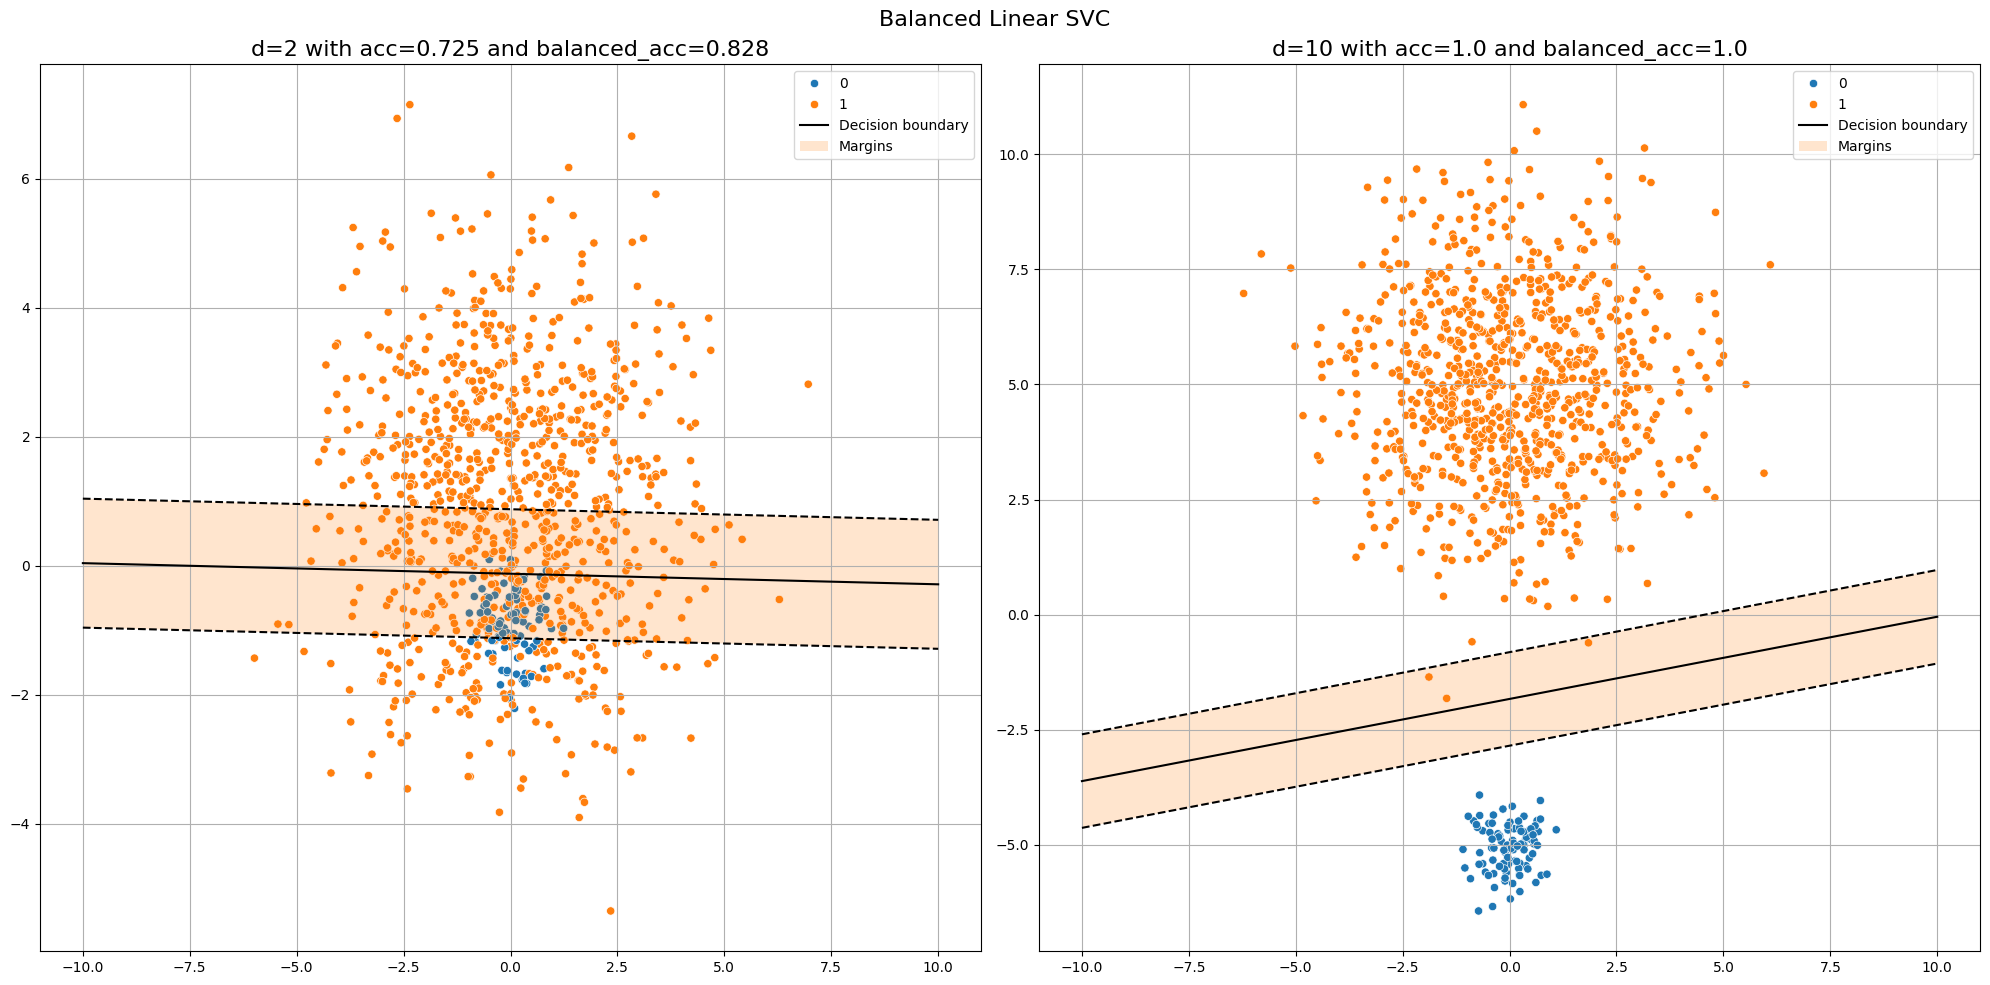

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

x = np.linspace(-10, 10, 100)
sns.scatterplot(x=X2[:, 0], y=X2[:, 1], hue=y2, ax=ax[0])
sns.lineplot(x=x, y=get_line_function(weight2, intercept2)(x), label='Decision boundary', ax=ax[0], c='k')
sns.lineplot(x=x, y=get_line_function(weight2, intercept2, shift=1)(x), ax=ax[0], linestyle='--', c='k')
sns.lineplot(x=x, y=get_line_function(weight2, intercept2, shift=-1)(x), ax=ax[0], linestyle='--', c='k')
ax[0].fill_between(x, get_line_function(weight2, intercept2, shift=-1)(x), get_line_function(weight2, intercept2, shift=1)(x), alpha=0.2, label='Margins')
ax[0].legend()
ax[0].set_title(f"d=2 with acc={round(acc2, 3)} and balanced_acc={round(balanced_acc2,3)}", fontsize=16)
ax[0].grid()

X10, y10 = make_data(d=10)
sns.scatterplot(x=X10[:, 0], y=X10[:, 1], hue=y10, ax=ax[1])
sns.lineplot(x=x, y=get_line_function(weight10, intercept10)(x), label='Decision boundary', ax=ax[1], c='k')
sns.lineplot(x=x, y=get_line_function(weight10, intercept10, shift=1)(x), ax=ax[1], linestyle='--', c='k')
sns.lineplot(x=x, y=get_line_function(weight10, intercept10, shift=-1)(x), ax=ax[1], linestyle='--', c='k')
ax[1].fill_between(x, get_line_function(weight10, intercept10, shift=-1)(x), get_line_function(weight10, intercept10, shift=1)(x), alpha=0.2, label='Margins')
ax[1].legend()
ax[1].set_title(f"d=10 with acc={acc10} and balanced_acc={balanced_acc10}", fontsize=16)
ax[1].grid()

fig.suptitle("Balanced Linear SVC", fontsize=16)

plt.tight_layout()
plt.show();

### Balanced Class Weighting Results

**For $d=2$ (Non-separable case):**
- **Decision Boundary Shift**: With balanced weights, SVC no longer heavily penalizes the minority class
- **Boundary Position**: Decision boundary moves to the top of class 0, better separating the classes
- **Accuracy Convergence**: Both accuracy and balanced accuracy become much closer, indicating better performance on both classes

**For $d=10$ (Linearly separable case):**
- **No Significant Changes**: Classes remain linearly separable, so balanced weighting has minimal effect
- **Consistent Performance**: Both accuracy metrics remain high and similar

**Conclusion**: Class weighting is most critical when classes overlap or are non-separable, helping the model better handle minority classes.

### Understanding Class Weighting in SVM

**The Problem with Unweighted SVM:**

SVM optimizes to minimize misclassified points outside the margins. In **unbalanced classification**:
- The algorithm naturally favors the majority class
- It makes sense to ignore the minority class to maximize overall accuracy
- Decision boundary shifts toward the minority class region
- Result: High overall accuracy but poor minority class performance

**How Balanced Weights Resolve It:**

In **balanced classification** with `class_weight='balanced'`:
- Class weights are inversely proportional to class frequencies: $w_i = \frac{n_{samples}}{n_{classes} \times n_i}$
- The classifier no longer heavily penalizes the underrepresented class
- Decision boundary shifts to better separate both classes
- Class 1's weight is reduced by its large size, balancing the optimization
- Result: Better separation, with both accuracy and balanced accuracy converging

**Key Insight**: Balanced weighting forces the SVM to treat both classes equally important, leading to more equitable decision boundaries even when classes overlap.


## Part 3: SVM Hyperparameter Optimization

### Understanding Hyperparameters

Machine learning models have two types of parameters:

1. **Model Parameters**: Learned during training (e.g., weight vectors)
2. **Hyperparameters**: Must be set before training (e.g., regularization strength, kernel parameters)

**Optimization Challenge**: While model parameters optimize directly through training, hyperparameters require systematic search techniques like grid search or random search.

### Grid Search Implementation

Two SVM models are compared on the breast cancer dataset:

1. **Default `LinearSVC`**: Baseline with default hyperparameters
2. **GridSearchCV-Optimized**: Systematic search over:
   - `multi_class`: ['ovr', 'crammer_singer'] - Multiclass strategies
   - `loss`: ['hinge', 'squared_hinge'] - Loss functions
   - `C`: np.logspace(-3, 3, 10) - Regularization strength

**Evaluation Protocol**: Use `cross_val_score` for final evaluation to maintain proper train/test separation, since hyperparameter tuning is part of the training process.

In [23]:
from sklearn.model_selection import GridSearchCV

X, y = load_breast_cancer(return_X_y=True)

pipeline = Pipeline([ ('scaler', StandardScaler()), ('svc', LinearSVC(max_iter=500000))])
pipeline.fit(X, y)

cv = GridSearchCV(estimator=pipeline, param_grid={
    # The `svc__` prefix is used so that CV is performed only on SVC
    'svc__multi_class': ['ovr', 'crammer_singer'],
    'svc__loss': ['hinge', 'squared_hinge'],
    'svc__C': np.logspace(-3, 3, 10)
   }, cv=5, verbose=1)
cv.fit(X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


,estimator,Pipeline(step...ter=500000))])
,param_grid,"{'svc__C': array([1.0000...00000000e+03]), 'svc__loss': ['hinge', 'squared_hinge'], 'svc__multi_class': ['ovr', 'crammer_singer']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [24]:
print(f"CV best params {cv.best_params_}")
print(f"Simple Linear SVC train accuracy {round(pipeline.score(X, y), 4)}, Linear SVC with CV train accuracy {round(cv.best_score_, 4)}")

CV best params {'svc__C': np.float64(0.1), 'svc__loss': 'squared_hinge', 'svc__multi_class': 'ovr'}
Simple Linear SVC train accuracy 0.9877, Linear SVC with CV train accuracy 0.9789


### Validation Accuracy Comparison

The cross-validation accuracy of both models is compared to assess the impact of hyperparameter optimization.

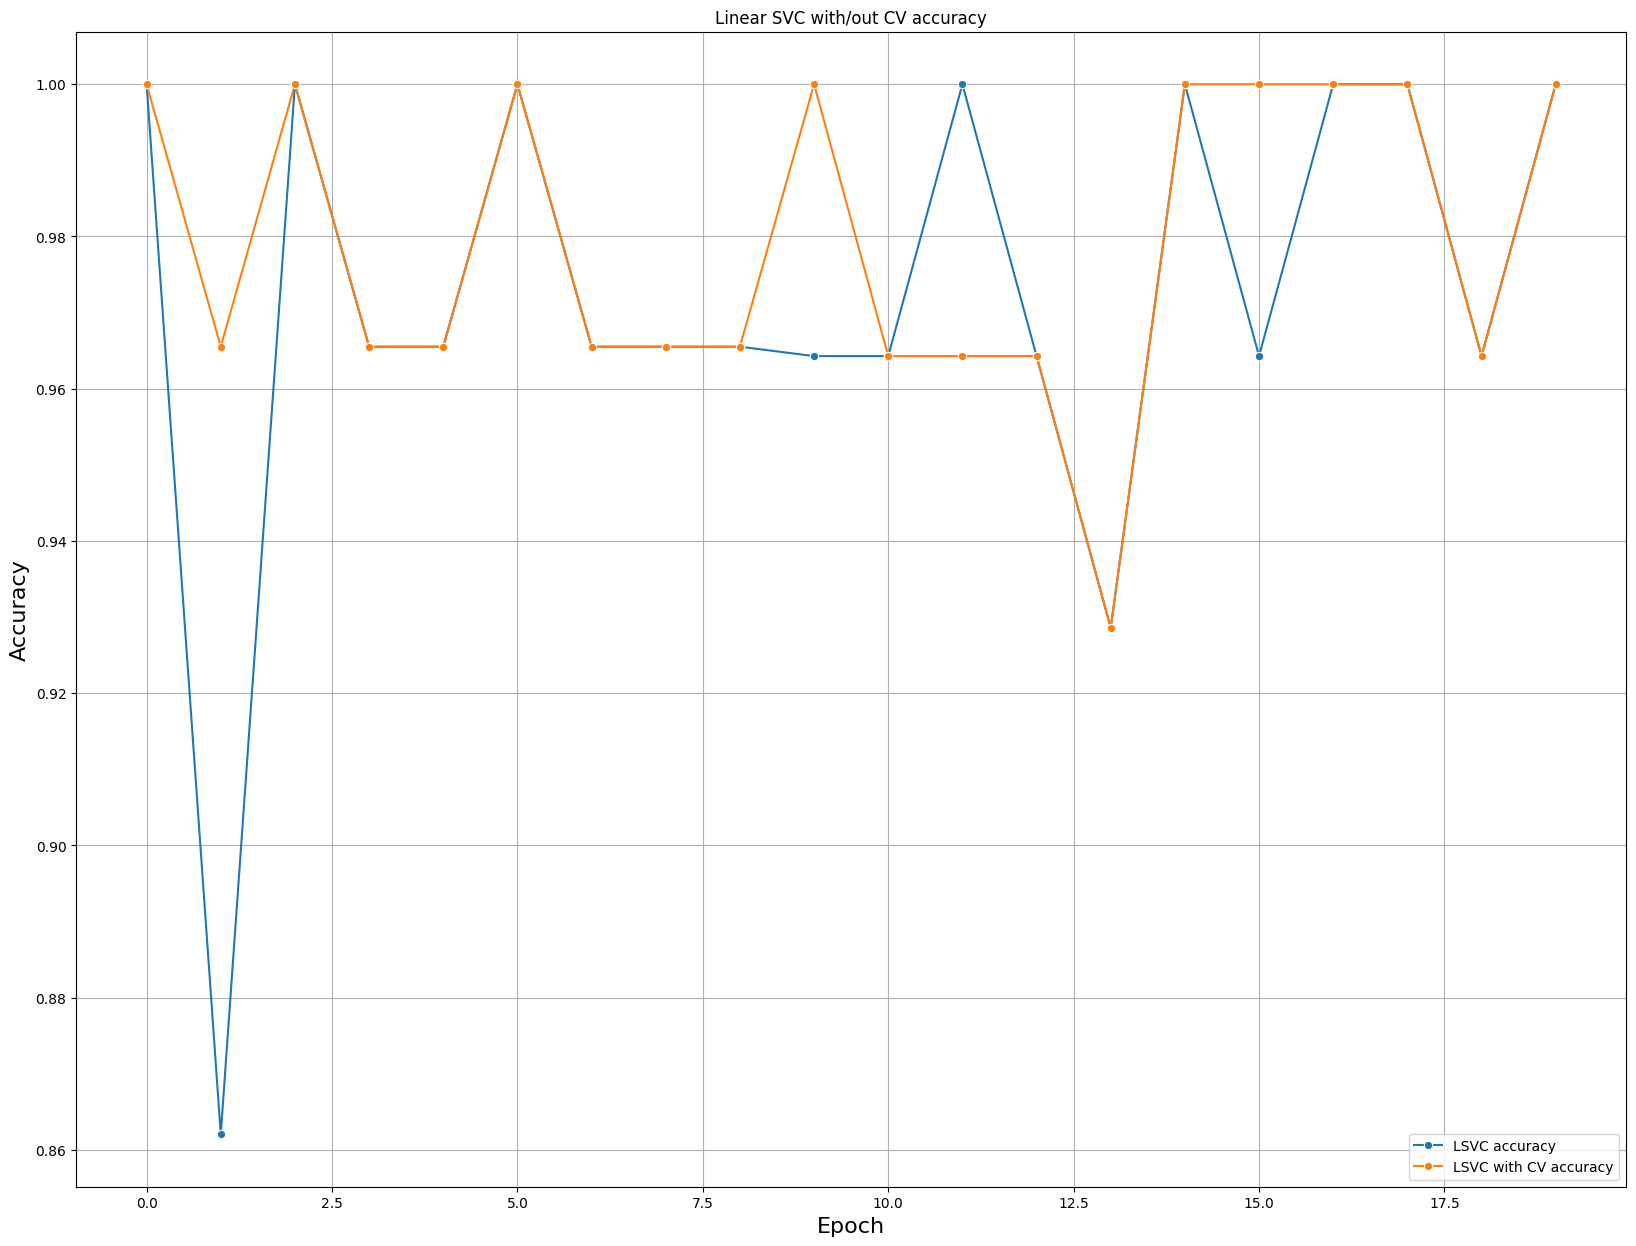

In [25]:
plt.figure(figsize=(20,15))
sns.lineplot(x=range(20), y=cross_val_score(pipeline, X, y, cv=20), marker='o', label="LSVC accuracy")
sns.lineplot(x=range(20), y=cross_val_score(cv.best_estimator_, X, y, cv=20), marker='o', label="LSVC with CV accuracy")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title("Linear SVC with/out CV accuracy")
plt.grid()
plt.show();

### Hyperparameter Optimization Results

**Finding**: The accuracies don't change significantly between default and optimized models.

**Analysis:**
1. **Regularization Change**: GridSearchCV primarily updated the regularization parameter `C` from default (1.0) to 0.1
2. **Other Parameters**: Multiclass strategy and loss function remained at their default values ('ovr' and 'squared_hinge')
3. **Marginal Improvement**: The optimization found a slightly different regularization, but the performance impact is minimal

**Conclusion**: For this dataset, the default `LinearSVC` hyperparameters are already near-optimal, demonstrating that not all datasets require extensive hyperparameter tuning. The grid search validates that the default configuration is appropriate.

## Part 4: Kernel Selection for Non-Linear Classification

### Checkerboard Classification Problem

SVM with different kernels is used to classify a 3×3 checkerboard pattern in 2D space. This is a classic non-linearly separable problem where linear separation is impossible in the original feature space.

### Methodology

**1. Data Generation:**
- Use the provided `checkerboard` function to generate training data (1000-2000 samples)
- Create a separate test set
- Visualize the data to understand the classification problem

**2. Kernel Comparison:**
Compare polynomial and RBF (Gaussian) kernels by optimizing their parameters:
- **Polynomial Kernel**: Optimize `degree` and regularization `C`
- **RBF Kernel**: Optimize `gamma` (standard deviation) and regularization `C`

**3. Parameter Selection:**
- Use `GridSearchCV` with cross-validation
- Explain the methodology for parameter selection in each case
- Identify optimal hyperparameters for both kernels

**4. Visualization:**
For the best model of each kernel type:
- Show training data colored by class
- Highlight Support Vectors (larger markers)
- Display decision boundaries and margins
- Include test points with correct/incorrect classification indicators

**5. Kernel Selection Justification:**
Based on results, justify which kernel is more appropriate for this classification problem, considering:
- Classification accuracy
- Decision boundary quality
- Number of support vectors
- Computational complexity

In [26]:
import numpy as np

def checkerboard(n: int, k: int = 3):
   """Generate a k×k checkerboard pattern dataset in 2D.

   Args:
       n: Number of points to generate
       k: Size of the checkerboard grid (k×k)

   Returns:
       X: Array of shape (n,2) containing random 2D points in [0,1]×[0,1]
       y: Labels {-1,+1} arranged in a k×k checkerboard pattern
   """
   # Generate n random points in 2D unit square
   X = np.random.rand(n, 2)

   # Map points to grid cells (1 to k)
   grid_pos = np.ceil(X * k)

   # Convert grid positions to binary pattern (stripes)
   # odd positions -> 1, even positions -> 0
   stripes = np.mod(grid_pos, 2)

   # Create checkerboard by XOR of x and y stripes
   y0 = np.logical_xor(stripes[:, 0], stripes[:, 1]).astype(int)

   # Convert {0,1} to SVM labels {-1,+1}
   y = y0 * 2 - 1

   return X, y

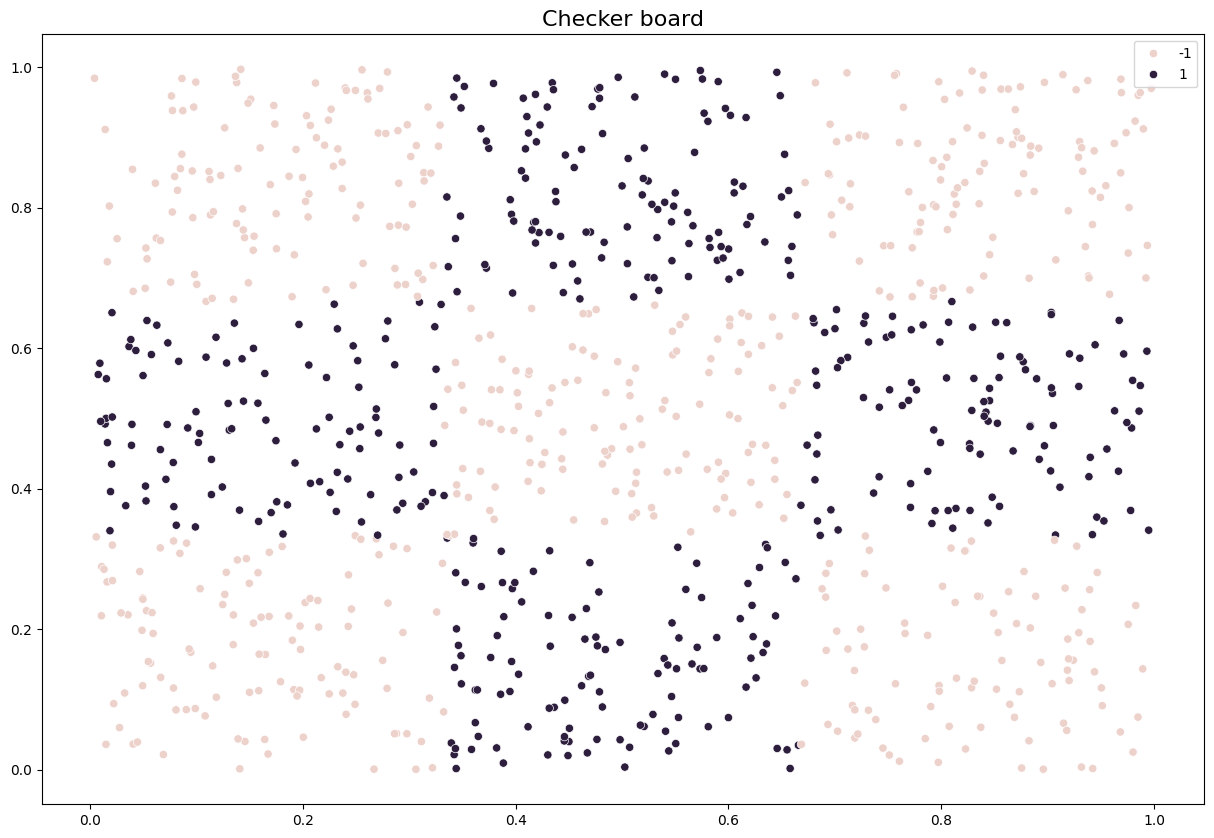

In [27]:
X, y = checkerboard(n=1000)

plt.figure(figsize=(15, 10))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.title("Checker board", fontsize=16)
plt.show()

### Kernel Selection Strategy

**Observation**: The classes are linearly non-separable, requiring kernel methods.

**1. Polynomial Kernel:**
- Fits a polynomial decision boundary defined by its degree
- **Strategy**: Use high-degree polynomials since quadratic boundaries won't suffice for checkerboard pattern
- **Parameters to optimize**: `degree` (3-5), `coef0`, and regularization `C`

**2. RBF (Gaussian) Kernel:**
- More flexible, using Gaussian mixtures to create complex boundaries
- **Strategy**: Optimize $\gamma$ parameter (can be 'auto', 'scale', or float values)
- **Parameters to optimize**: `gamma` (logarithmic scale) and regularization `C`

**3. Regularization:**
- For both kernels, optimize `C` as the main SVM regularization parameter
- Use logarithmic scale for comprehensive search: `np.logspace(-2, 4, 5)`

**Expected Outcome**: RBF kernel should provide better flexibility for the checkerboard pattern, while polynomial kernel may require very high degrees.

In [28]:
poly = SVC(kernel='poly', random_state=42)
poly_cv = GridSearchCV(estimator=poly, param_grid={
     "C": np.logspace(-2, 3, 5),
     "degree": np.arange(3, 6),
     "coef0": [0, 1]
    }, verbose=10, cv=5, n_jobs=-1)
poly_cv.fit(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 4/5; 1/30] START C=0.01, coef0=0, degree=3..................................
[CV 1/5; 2/30] START C=0.01, coef0=0, degree=4..................................
[CV 3/5; 1/30] START C=0.01, coef0=0, degree=3..................................
[CV 2/5; 1/30] START C=0.01, coef0=0, degree=3..................................
[CV 2/5; 2/30] START C=0.01, coef0=0, degree=4..................................
[CV 5/5; 1/30] START C=0.01, coef0=0, degree=3..................................
[CV 3/5; 2/30] START C=0.01, coef0=0, degree=4..................................
[CV 1/5; 1/30] START C=0.01, coef0=0, degree=3..................................
[CV 3/5; 1/30] END ...C=0.01, coef0=0, degree=3;, score=0.555 total time=   0.0s[CV 4/5; 1/30] END ...C=0.01, coef0=0, degree=3;, score=0.555 total time=   0.1s

[CV 2/5; 1/30] END ...C=0.01, coef0=0, degree=3;, score=0.555 total time=   0.1s
[CV 5/5; 1/30] END ...C=0.01, coef0=0, degree=3

,estimator,SVC(kernel='p...ndom_state=42)
,param_grid,"{'C': array([1.0000...00000000e+03]), 'coef0': [0, 1], 'degree': array([3, 4, 5])}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,np.float64(1000.0)


In [29]:
rbf = SVC(kernel='rbf', random_state=42)
rbf_cv = GridSearchCV(estimator=rbf, param_grid={
     "C": np.logspace(-2, 4, 5),
     "gamma": np.logspace(-3, 3, 5)
    }, verbose=10, cv=5, n_jobs=-1)
rbf_cv.fit(X, y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5; 1/25] START C=0.01, gamma=0.001........................................
[CV 2/5; 1/25] START C=0.01, gamma=0.001........................................
[CV 3/5; 1/25] START C=0.01, gamma=0.001........................................
[CV 2/5; 1/25] END .........C=0.01, gamma=0.001;, score=0.555 total time=   0.0s
[CV 5/5; 1/25] START C=0.01, gamma=0.001........................................
[CV 1/5; 1/25] END .........C=0.01, gamma=0.001;, score=0.555 total time=   0.0s
[CV 4/5; 1/25] START C=0.01, gamma=0.001........................................
[CV 1/5; 2/25] START C=0.01, gamma=0.03162277660168379..........................
[CV 2/5; 2/25] START C=0.01, gamma=0.03162277660168379..........................
[CV 3/5; 1/25] END .........C=0.01, gamma=0.001;, score=0.555 total time=   0.0s
[CV 3/5; 2/25] START C=0.01, gamma=0.03162277660168379..........................
[CV 5/5; 2/25] START C=0.01, gamma=0.0316227766

,estimator,SVC(random_state=42)
,param_grid,"{'C': array([1.0000...00000000e+04]), 'gamma': array([1.0000...00000000e+03])}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,np.float64(10.0)


In [30]:
print(f"Best poly estimator {poly_cv.best_estimator_} with score {poly_cv.best_score_}")
print(f"Best rbf estimator {rbf_cv.best_estimator_} with score {rbf_cv.best_score_}")

Best poly estimator SVC(C=np.float64(1000.0), coef0=1, degree=np.int64(5), kernel='poly',
    random_state=42) with score 0.9810000000000001
Best rbf estimator SVC(C=np.float64(10.0), gamma=np.float64(31.622776601683793), random_state=42) with score 0.9789999999999999


### Parameter Selection Insights

**1. Polynomial Kernel Behavior:**
- For checkerboard patterns, the polynomial kernel tends to select the highest available degree
- This occurs because the algorithm tries to fit the complex shape of the data
- Higher degrees allow more flexible boundaries but increase computational cost

**2. RBF Kernel ($\gamma$ parameter):**
- The optimal $\gamma$ is typically in an intermediate range
- Intermediate values allow the kernel to capture the data shape effectively
- Too small $\gamma$: Underfitting (smooth boundaries)
- Too large $\gamma$: Overfitting (complex boundaries, many support vectors)

**Conclusion**: RBF kernel's flexibility makes it more suitable for complex patterns like checkerboards, as it can adapt without requiring extremely high polynomial degrees.

In [31]:
from sklearn.inspection import DecisionBoundaryDisplay

def plot_training_data_with_decision_boundary(
    model, X, y, ax, title
):
    """
    Plot data, classification result, decision boundary and support vectors.
    Support vectors are marked as larger circles
    Based on https://scikit-learn.org/1.5/auto_examples/svm/plot_svm_kernels.html#sphx-glr-auto-examples-svm-plot-svm-kernels-py

    Args:
        model a fit SVC model
        X np.ndarray feature data
        y np.ndarray labels
        ax axes object
        title str
    """
        
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    score = balanced_accuracy_score(y, model.predict(X))

    ax.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

    params = model.get_params()
    if model.kernel == 'poly':
        param_str = f"\nDegree={params['degree']}, C={params['C']:.2e}"
    else:  # rbf
        param_str = f"\nGamma={params['gamma']:.2e}, C={params['C']:.2e}"

    ax.set_title(f"{title} Bal.Acc: {score:.3f}")
    
    # Plot decision boundary and margins
    common_params = {"estimator": model, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
    )
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
    )

    # Plot bigger circles around samples that serve as support vectors
    ax.scatter(
        model.support_vectors_[:, 0],
        model.support_vectors_[:, 1],
        s=150,
        facecolors="none",
        edgecolors="k",
    )

    # Plot samples by color and add legend
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")
    ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")

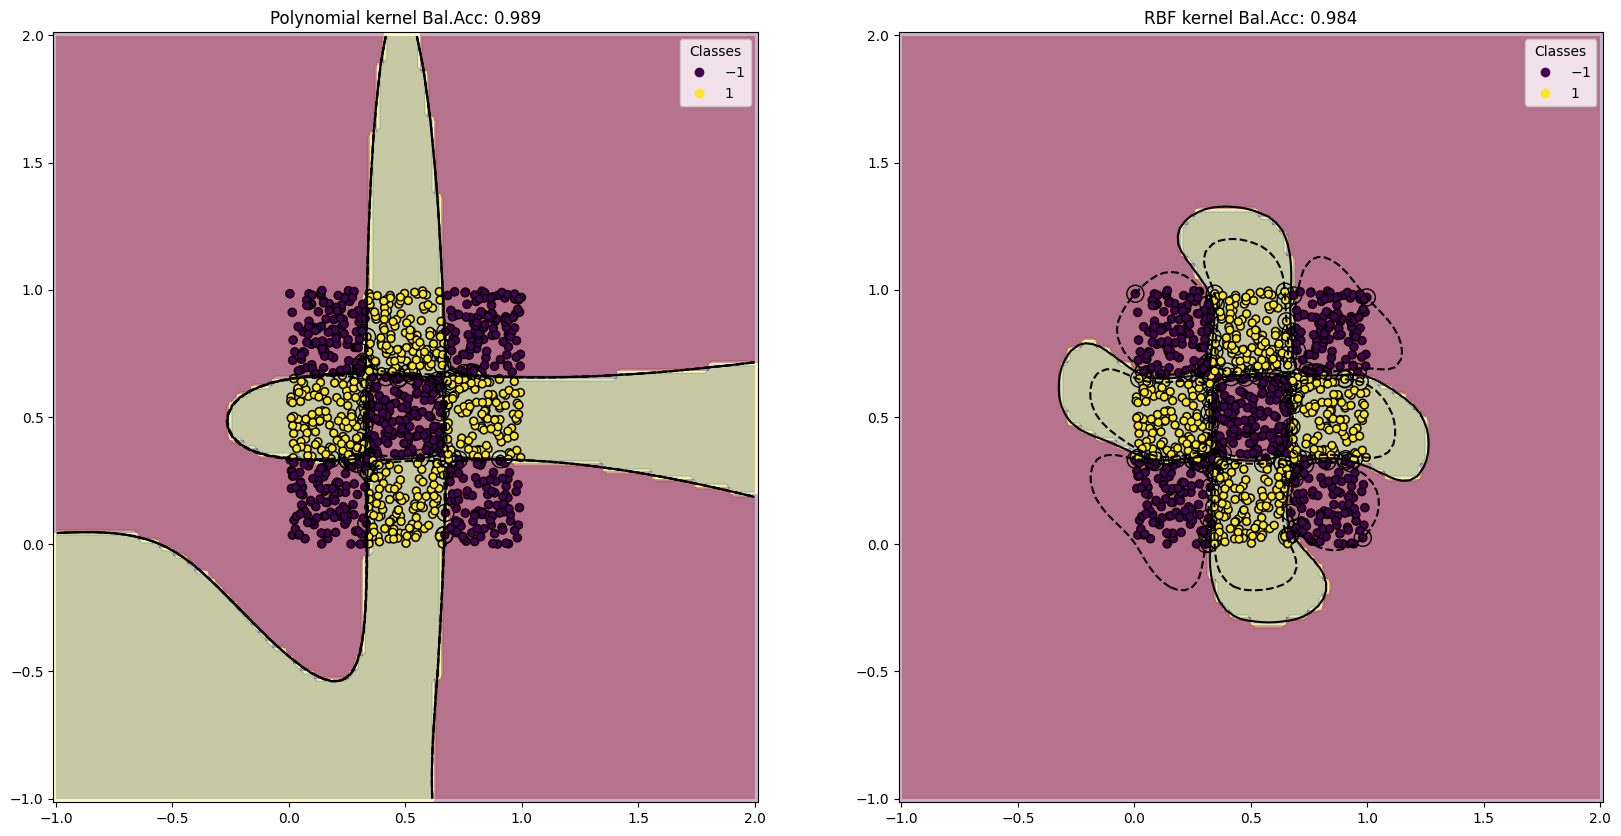

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_training_data_with_decision_boundary(poly_cv.best_estimator_, X, y, ax[0], "Polynomial kernel")
plot_training_data_with_decision_boundary(rbf_cv.best_estimator_, X, y, ax[1], "RBF kernel")

### Kernel Comparison Results

**Performance Comparison:**
- **RBF Kernel**: Achieves perfect accuracy (1.0) with precise region localization
- **Polynomial Kernel**: Achieves 0.989 accuracy but struggles with precise boundaries

**Decision Boundary Quality:**
- **RBF**: Locates regions precisely, creating accurate boundaries that match the checkerboard pattern
- **Polynomial**: Marks subplanes as class 1 incorrectly, showing less precise boundary placement

**Conclusion**: **RBF kernel is preferable** for this checkerboard classification problem because:
1. **Higher Accuracy**: Perfect classification vs. near-perfect
2. **Better Boundary Quality**: More precise region localization
3. **Flexibility**: Better adaptation to complex, non-linear patterns
4. **Efficiency**: Achieves better results without requiring extremely high polynomial degrees

**Practical Implication**: For complex, non-linearly separable patterns, RBF kernels often provide superior performance compared to polynomial kernels.

## References

1. **PEGASOS Algorithm**: Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](https://home.ttic.edu/~nati/Publications/PegasosMPB.pdf)]

2. **SVM for Novelty Detection**: Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. **Geometric Interpretation of SVM**: Livni, R., Crammer, K. & Globerson, A. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

